# Accumulated Local Effects for classifying flowers

In this example we will explain the behaviour of classification models on the Iris dataset. It is recommended to first read the [ALE regression example](ale_regression_boston.ipynb). Interpreting ALE plots for classification problems become more complex due to to reasons:

 - Instead of one ALE line for each feature we now have one for each class to explain the feature effects towards predicting each class.
 - There are two ways to choose the prediction function to explain:
   - Class probability predictions (e.g. `clf.predict_proba` in `sklearn`)
   - Margin or logit predictions (e.g. `clf.decision_function` in `sklearn`)
   
We will see the implications of explaining each of these prediction functions.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from alibi.explainers.ale import ALE, plot_ale

## Load and prepare the dataset

In [2]:
data = load_iris()
feature_names = data.feature_names
target_names = data.target_names
X = data.data
y = data.target

Shuffle the data and define the train and test set:

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

## Fit and evaluate a logistic regression model

In [4]:
lr = LogisticRegression(max_iter=200)

In [5]:
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=200,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [6]:
accuracy_score(y_test, lr.predict(X_test))

1.0

## Calculate Accumulated Local Effects

There are several options for explaining the classifier predictions using ALE. We define two prediction functions, one in the unnormalized logit space and the other in probability space, and look at how the resulting ALE plot interpretation changes.

In [7]:
logit_fun_lr = lr.decision_function
proba_fun_lr = lr.predict_proba

In [21]:
logit_ale_lr = ALE(logit_fun_lr, feature_names=feature_names, target_names=target_names)
proba_ale_lr = ALE(proba_fun_lr, feature_names=feature_names, target_names=target_names)

In [23]:
logit_exp_lr = logit_ale_lr.explain(X_train)
proba_exp_lr = proba_ale_lr.explain(X_train)

## ALE in logit space

We first look at the ALE plots for explaining the feature effects towards the unnormalized logit scores:

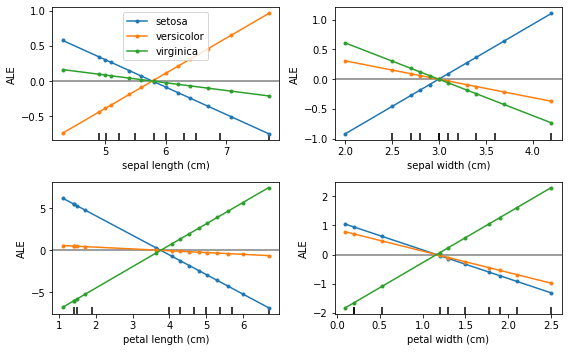

In [24]:
plot_ale(logit_exp_lr, n_cols=2, fig_kw={'figwidth': 8, 'figheight': 5}, sharey=None);

We see that the feature effects are linear for each class and each feature. This is exactly what we should expect because the logistic regression is a linear model in the logit space.

Furthermore, the units of the ALE plots here are in logits which means that the feature effect at some feature value will be a positive or negative contribution to the logit of each class with respect to the mean feature effect.

Let's look at the interpretation of the feature effects for "petal length" in more detail:

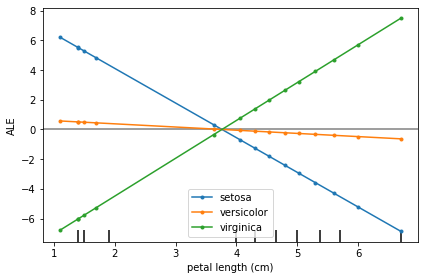

In [25]:
plot_ale(logit_exp_lr, features=[2]);

The ALE lines cross the 0 mark at ~3.8cm which means that for instances of petal length around ~3.8cm the feature effect on the prediction is the same as the average feature effect.  On the other hand, going towards the extreme values of the feature, the model assigns a large positive/negative penalty towards classifying instances as "setosa" and vice versa for the other two classes.

We can go into a bit more detail about the "mean response" at the petal length around ~3.8cm. First, we calculate the mean response (in logit space) of the model on the training set:

In [26]:
mean_logits = logit_fun_lr(X_train).mean(axis=0)
mean_logits

array([-0.64214307,  2.26719121, -1.62504814])

Next, we find instances for which the feature "petal length" is close to ~3.8cm and look at the predictions for these:

In [27]:
lower_index = np.where(logit_exp_lr.feature_values[2] < 3.8)[0][-1]
upper_index = np.where(logit_exp_lr.feature_values[2] > 3.8)[0][0]
subset = X_train[(X_train[:, 2] > logit_exp_lr.feature_values[2][lower_index])
                 & (X_train[:, 2] < logit_exp_lr.feature_values[2][upper_index])]
print(subset.shape)

(8, 4)


In [28]:
subset_logits = logit_fun_lr(subset).mean(axis=0)
subset_logits

array([-1.33625605,  2.32669999, -0.99044394])

Now if we sum the the mean logits and the logits of the instances for which petal length is ~3.8, because $\text{ALE}(4)\approx 0$ for petal length, the difference must be due to the effect of all other features:

In [29]:
subset_logits - mean_logits

array([-0.69411298,  0.05950878,  0.6346042 ])

For example, the remaining 3 features combined must be responsible for a positive effect of around ~0.69 on predicting instances with petal length ~3.8cm to be of class `setosa`.

We can gain even more insight into the ALE plot by looking at the class histograms for the feature `petal length`:

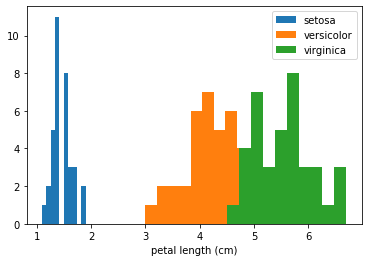

In [30]:
fig, ax = plt.subplots()
for target in range(3):
    ax.hist(X_train[y_train==target][:,2], label=target_names[target]);

ax.set_xlabel(feature_names[2])
ax.legend();

Here we see that the three classes are very well separated by this feature. This confirms that the ALE plot is behaving as expected—the feature effects of small value of "petal length" are that of increasing the the logit values for the class "setosa" and decreasing for the other two classes. Also note that the range of the ALE values for this feature is particularly high compared to other features which can be interpreted as the model attributing more importance to this feature as it separates the classes well on its own.

## ALE in probability space

We now turn to interprting the ALE plots for explaining the feature effects on the probabilities of each class.

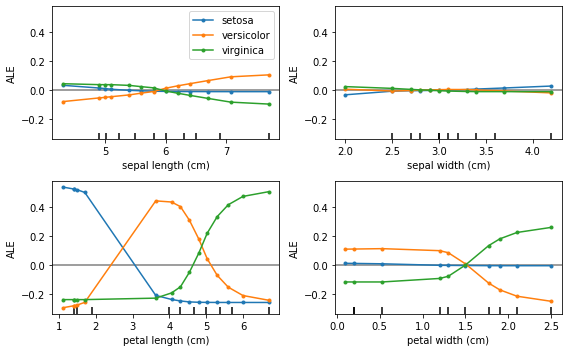

In [31]:
plot_ale(proba_exp_lr, n_cols=2, fig_kw={'figwidth': 8, 'figheight': 5});

As expected, the ALE plots are no longer linear which reflects the non-linear nature of applying the softmax transformation to the linear logit scores.

Note that in this case the ALE are in the units of relative probability mass, i.e. given a feature value how much more (less) probability does the model assign to each class relative to the mean prediction. This also means that any increase in relative probability to one class must result into a decrease in probability to another class, in fact the ALE lines summed across classes result in 0 as a direct consequence of conservation of probability:

In [34]:
for feature in range(4):
    print(proba_exp_lr.ale_values[feature].sum())

-5.551115123125783e-17
1.734723475976807e-17
-6.661338147750939e-16
4.440892098500626e-16


By transforming the ALE plots into probability space we can gain additional insight into the model behaviour. For example, the ALE curve for the feature `petal width` and class `setosa` is virtually flat. This means that the model does not use this feature to assign higher or lower probability to class `setosa` with respect to the average prediction. This is not readily seen in logit space as the ALE curve has negative slope which would lead us to the opposite conclusion. The interpretation here is that even though the ALE curve in the logit space shows a negative effect with feature value, the effect in the logit space is not significant enought to translate into a tangible effect in the probability space.

Finally, the feature `sepal width` does not offer significant information to the model to prefer any class over the other (with respect to the mean effect of `sepal_width` that is). If we plot the marginal distribution of `sepal_width` it explains why that is—the per-class histograms are simply overlapping too much to offer much discriminative power to the linear model:

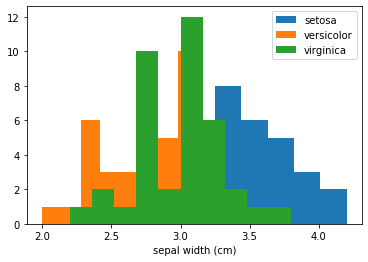

In [35]:
fig, ax = plt.subplots()
for target in range(3):
    ax.hist(X_train[y_train==target][:,1], label=target_names[target]);

ax.set_xlabel(feature_names[1])
ax.legend();

## ALE for gradient boosting

Finally, we look at the resulting ALE plots for a highly non-linear model—a gradient boosted classifier.

In [36]:
from sklearn.ensemble import GradientBoostingClassifier

In [37]:
gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [38]:
accuracy_score(y_test, gb.predict(X_test))

1.0

As before, we explain the feature contributions in both logit and probability space.

In [39]:
logit_fun_gb = gb.decision_function
proba_fun_gb = gb.predict_proba

In [40]:
logit_ale_gb = ALE(logit_fun_gb, feature_names=feature_names, target_names=target_names)
proba_ale_gb = ALE(proba_fun_gb, feature_names=feature_names, target_names=target_names)

In [41]:
logit_exp_gb = logit_ale_gb.explain(X_train)
proba_exp_gb = proba_ale_gb.explain(X_train)

### ALE in logit space

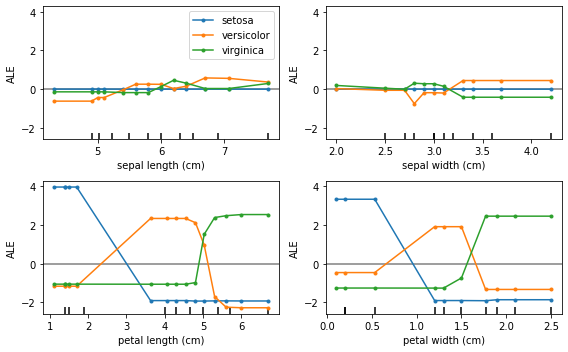

In [42]:
plot_ale(logit_exp_gb, n_cols=2, fig_kw={'figwidth': 8, 'figheight': 5});

The ALE curves are no longer linear as the model used is non-linear. Furthermore, we've plotted the ALE curves of different features on the same scale on the $y$-axis which suggests that the features `petaln length` and `petal width` are more discriminative for the task. Checking the feature importances of the classifier confirms this:

In [43]:
gb.feature_importances_

array([0.00217251, 0.01533021, 0.5350348 , 0.44746247])

### ALE in probability space

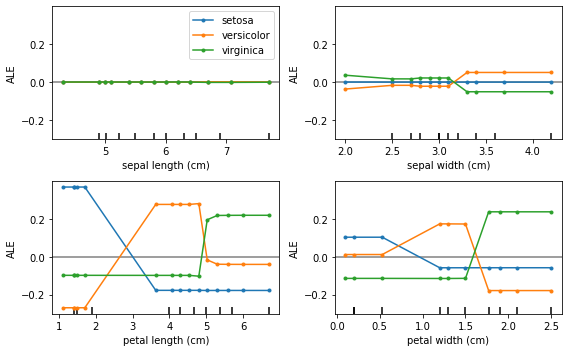

In [44]:
plot_ale(proba_exp_gb, n_cols=2, fig_kw={'figwidth': 8, 'figheight': 5});

Because of the non-linearity of the gradient boosted model the ALE curves in probability space are very similar to the curves in the logit space just on a different scale.

### Comparing ALE between models

We have seen that for both logistic regression and gradient boosting models the features `petal length` and `petal width` have a high feature effect on the classifier predictions. We can explore this in more detail by comparing the ALE curves for both models. In the following we plot the ALE curves of the two features for predicting the class `setosa` in probability space:

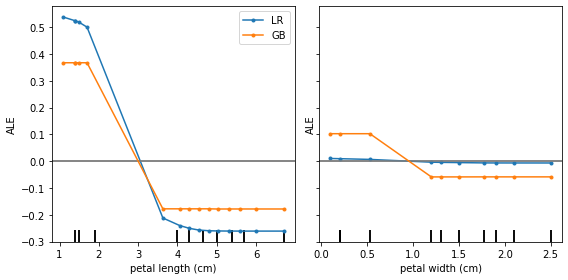

In [54]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4), sharey='row');
plot_ale(proba_exp_lr, features=[2, 3], targets=['setosa'], ax=ax, line_kw={'label': 'LR'});
plot_ale(proba_exp_gb, features=[2, 3], targets=['setosa'], ax=ax, line_kw={'label': 'GB'});

From this plot we can draw several conclusions:
 - Both models have similar feature effects of `petal length`—a high positive effect for predicting `setosa` for small feature values and a high negative effect for large values (over >3cm).
 - Overall the effects of `petal length` on the predicted probability outweigh the effects of `petal width`
 - Whils the logistic regression model does not benefit from the `petal width` feature to discriminate the `setosa` class, the gradient boosted model does exploit this feature and can increase its discriminative power.